# <center>RDRP Kinetic Simulator - by the Method of Moments </center>

<center>Version 1.0</center>

## About this program


This a reversible-deactivation radical polymerization (RDRP) kinetic simulator based on the method of moments.[1][2] The types of polymerizations supported are conventional radical polymerization, normal atom transfer radical polymerization (ATRP), activators generated by electron transfer (AGET) ATRP, activators regenerated by electron transfer (ARGET) ATRP, supplemental activator and reducing agent (SARA) ATRP, electrochemically mediated ATRP (*e*ATRP), ATRP by continuous feeding of activators (CFA), initiators for continuous activator regeneration (ICAR) ATRP, nitroxide mediated polymerization (NMP), and reversible addition-fragmentation chain transfer (RAFT). The input includes the reaction time, the initial concentrations of reagents, and the rate coefficients of all reactions involved. The results provide the concentration changes of all species vs. time, the monomer conversion vs. time, the number average molecular weight vs. time, molecular weight distribution vs. time, and the mole percent of end group loss vs. time. All results could be exported to a CSV file. 

For more information, please visit [https://wangyu16.github.io/macroarchilab/simulation/RDRP-kinetic-simulator/](https://wangyu16.github.io/macroarchilab/simulation/RDRP-kinetic-simulator/). 

To download this program, please visit [https://github.com/wangyu16/PolymerScienceEducation](https://github.com/wangyu16/PolymerScienceEducation).

[1]: Shiping Zhu, Modeling of molecular weight development in atom transfer radical polymerization, *Macromol. Theory Simul.* **1999**, *8*, 29–37.  
[2]: Erlita Mastan and Shiping Zhu, Method of moments: A versatile tool for deterministic modeling of polymerization kinetics, *European Polymer Journal* **2015**, *68*, 139–160.

**System requirement**

This program is written in Python and runs in Jupyter Notebook. The easiest way to set up the Jupyter Notebook is to install [Anaconda](https://www.anaconda.com/distribution/) which includes python, Jupyter Notebook and many python packages for scientific programming. Make sure you choose Python 3.6 or above because it is required for this program. After installing Anaconda, you also need to install a python package named ['chempy'](https://pypi.org/project/chempy/).   

**Not sure what you can change in the code?**

No worry! If you are not familiar with programming, all that you may change are located in the section "**Reaction conditions**". For example, in the following code block, you can change the red colored word 'normal' after "Poly_type = ", and the green colored number 90000 after "react_time = ". 

```python
# 'sara' for SARA ATRP;
# 'cfa' for ATRP by continuous feeding of activators;
# 'icar' for ICAR ATRP.
Poly_type = 'normal' 

############################    
# 2. Set the reaction time #
############################ 
# This is a required section.
# Set reaction time limit in seconds. 
react_time = 90000 
```

Similarly, in the following code, only change the green colored numbers. 

```python
# Set the rate coefficients for the addition of the first monomer to the primary radical;
# the termination between primary radicals; the termination between a primary radical and a propagating radical. 
k_p_R = 1.3e3 
k_t_R = 1e9 
k_t_R_Pn = 1e9
```

## Import packages 

In [2]:
from chempy import ReactionSystem, Substance
from chempy.kinetics.ode import get_odesys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import datetime
import csv

ModuleNotFoundError: No module named 'chempy'

## Reaction conditions

In [3]:
###################################
# 1. Select the type of reaction # 
###################################
# This is a required section. 
# Choose the type of polymerization you want to simulate
# by setting the value of Poly_type as:
# 'conven' for conventional radical polymerization;
# 'normal' for normal ATRP;
# 'arget' for ARGET and AGET ATRP;
# 'eatrp' for electrochemical ATRP;
# 'sara' for SARA ATRP;
# 'cfa' for ATRP by continuous feeding of activators;
# 'icar' for ICAR ATRP;
# 'nmp' for NMP;
# 'raft' for RAFT. 
Poly_type = 'conven'

############################    
# 2. Set the reaction time #
############################ 
# This is a required section.
# Set reaction time limit in seconds. 
# For a 10 hour reaction, you can set the time as 36000 or 10*3600.
react_time = 15*3600 

###########################################################
# 3. Set the initial concentrations and rate coefficients #
###########################################################
   
##############################
# 3.1. Monomer concentration #
##############################
# This is a required section.
# Set the initial concentration of monomer. All the concentrations are in M/L unless otherwise specified.
c0_M = 5 
# Set the molecular weight of the monomer. 
MM = 100.12

####################################
# 3.2. Propagation and termination #
####################################
# This is a required section.
# Set the rate coefficients for propagation and termination (by coupling or by disproportionation).
# To find the propagation rate coefficient, see http://www.ceic.unsw.edu.au/kpcalculator/kp.html
# Chain transfer is neglected. 
k_p = 833 
k_tc = 2e8 
k_td = 1e8

# Set the rate coefficients for the addition of the first monomer to the primary radical;
# the termination between primary radicals; the termination between a primary radical and a propagating radical. 
k_p_R = 833
k_t_R = 3e8
k_t_R_Pn = 3e8 

####################################################################
# 3.3. For conventional radical polymerization, ICAR ATRP and RAFT #
####################################################################
# If thermal initiator (TI), e.g., AIBN, is used in your reaction,
# set the initial concentration of the initiator.
c0_TI = 0.1

# Set the decomposition rate coefficient and the initiation efficiency for the initiator.
k_d_TI = 1e-5
f_TI = 0.6

##############################
# 3.4. For all kinds of RDRP #
##############################
# Set the initial concentration of RX. 
c0_RX = 0.05 

##############################
# 3.5. For all kinds of ATRP #
##############################
# Set the initial concentration of Cu(I) and Cu(II).
# Assume there is sufficient amount of ligand to coordinate with all Cu(I) and Cu(II),
# and the concentration of free ligand does not affect the reaction kinetics. 
c0_CuI = 0 
c0_CuII = 5e-4 

# Set the rate coefficients for activation of RX; deactivation of radical R;  
# activation of a polymer with a halogen chain end; deactivation of a propagating radical. 
k_a_0_atrp = 14
k_d_0_atrp = 4.7e7 
k_a_atrp = 140 
k_d_atrp = 4.7e7

##################################   
# 3.5.1. For AGET and ARGET ATRP #
##################################
# Set the initial concentration of the reducing agent. 
c0_Reduc = 2.5e-3 

# Set the reduction rate coefficient
k_reduc = 1e-1 

####################
# 3.5.2. For eATRP #
####################
# set the initial concentration of the electrons as a large number, e.g. > 200 times of RX, 
# which will remain nearly constant.
c0_elec = 10 

# Set the rate coefficient of electronic reduction. This will mimic an eATRP process with constant current. 
k_e_reduc = 1e-7 

###################
# 3.5.3. For SARA #
###################
# set the initial concentration of Cu(0) in cm^2/mL. 
c0_Cu0 = 2 

# Set the rate coefficients of Cu(0) activation and comproportionation.
# Deactivation by Cu(I) and disproportionation are neglected. 
k_comp = 1e-4 
k_a_Cu0 = 1e-4 

#######################################################
# 3.5.4. For ATRP by continuous feeding of Activators #
#######################################################
# Set the initial concentration of Cu(I) source as any large number, e.g. > 200 times of RX, which will remain nearly constant. 
c0_CuIsour = 10 

# Set the rate coefficient to minic different feeding rate. 
k_cfa = 1.4e-8 

################
# 3.6. For NMP #
################
# Set the rate coefficients of activation (i.e., dissociation) and deactivation (i.e., coupling). 
k_a_0_nmp = 1
k_d_0_nmp = 1e8
k_a_nmp = 1
k_d_nmp = 1e8

#################
# 3.7. For RAFT #
#################
# Set the rate coefficients of activation (i.e., fragmentation) and deactivation (i.e., addition).
k_a_0_raft = 1e6
k_d_0_raft = 1e8
k_a_raft = 1e6
k_d_raft = 1e8

## Construct the reaction system

In [4]:
# Initiate the reaction system with null value. 
# The rsys_orig is the system of the actual reactions.
# The rsys_pseudo includes the pseudo reactions with pseudo species which are used to introduce 1st and 2nd order moments
# and to adjust the reactions to take into account the initiation efficiency, etc. 
rsys_orig = ReactionSystem.from_string("""
    """, substance_factory=Substance)
rsys_pseudo =  ReactionSystem.from_string("""
    """, substance_factory=Substance)

# Initial concentrations of monomer, dead chains, radicals and pseudo species of moments.
c0 = defaultdict(float, {'M': c0_M, 'D': 0, 'PnD': 0, 'PnDPn': 0, 'R': 0, 'Pn': 0, 'M1_Pn': 0, \
                         'M1_PnX': 0, 'M1_PnD': 0, 'M1_PnDPn': 0, 'M2_total': 0}) 

# Add propagation and termination reactions to the reaction system. 
rsys_orig += ReactionSystem.from_string(f"""
    R + M -> Pn; {k_p_R}
    Pn + M -> Pn; {k_p}      
    R + R -> D + D; {0.5*k_t_R}
    Pn + R -> PnD; {0.5*k_t_R_Pn}
    Pn + Pn -> PnD + PnD; {0.5*k_td}
    Pn + Pn -> PnDPn; {0.5*k_tc}
    """, substance_factory=Substance)
rsys_pseudo += ReactionSystem.from_string(f"""
    R + M -> R + M + M1_Pn + M2_total; {k_p}
    Pn + M -> Pn + M + M1_Pn + M2_total; {k_p}
    M1_Pn + M -> M1_Pn + M + M2_total; {2*k_p}
    M1_Pn + R -> M1_PnD + R; {0.5*k_t_R_Pn}
    M1_Pn + Pn -> M1_PnD + Pn; {k_td}
    M1_Pn + Pn -> M1_PnDPn + Pn; {k_tc}
    M1_Pn + M1_Pn -> M1_Pn + M1_Pn + M2_total; {k_tc}
    """, substance_factory=Substance)

# For all kinds of RDRP
if Poly_type != 'conven':
    c0.update({'RX': c0_RX, 'PnX':0})
    
# For all kinds of ATRP 
if Poly_type != 'conven' and  Poly_type != 'nmp' and Poly_type != 'raft':
    c0.update({'CuI': c0_CuI, 'CuII': c0_CuII})
    rsys_orig += ReactionSystem.from_string(f"""
        CuI + RX -> CuII + R; {k_a_0_atrp}     
        CuII + R -> CuI + RX; {k_d_0_atrp}
        CuI + PnX -> CuII + Pn; {k_a_atrp}
        CuII + Pn -> CuI + PnX; {k_d_atrp}        
        """, substance_factory=Substance)  
    rsys_pseudo += ReactionSystem.from_string(f"""
        M1_PnX + CuI -> M1_Pn + CuI; {k_a_atrp}
        M1_Pn + CuII -> M1_PnX + CuII; {k_d_atrp}
        """, substance_factory=Substance) 
    
# For AGET and ARGET ATRP
if Poly_type == 'arget':
    c0.update({'Reduc': c0_Reduc, 'ReducX':0})

    rsys_orig += ReactionSystem.from_string(f"""
        Reduc + CuII -> ReducX + CuI; {k_reduc}
        """, substance_factory=Substance)    
      
# For eATRP 
if Poly_type == 'eatrp':
    c0.update({'elec': c0_elec})    

    rsys_orig += ReactionSystem.from_string(f"""
        elec + CuII -> CuI; {k_e_reduc}
        """, substance_factory=Substance)

# For SARA ATRP
if Poly_type == 'sara':
    c0.update({'Cu0': c0_Cu0})    

    rsys_orig += ReactionSystem.from_string(f"""
        Cu0 + CuII -> CuI + CuI; {k_comp}
        Cu0 + RX -> CuI + R; {k_a_Cu0}
        """, substance_factory=Substance)

# For ATRP by continuous feeding of activators
if Poly_type == 'cfa':
    c0.update({'CuIsour': c0_CuIsour})    

    rsys_orig += ReactionSystem.from_string(f"""
        CuIsour -> CuI; {k_cfa}
        """, substance_factory=Substance)    

# For conventional radical polymerization ICAR ATRP and raft 
if Poly_type == 'conven' or Poly_type == 'icar' or Poly_type == 'raft':
    c0.update({'TI': c0_TI, 'PR': 0})   
    rsys_orig += ReactionSystem.from_string(f"""
        TI -> R + R; {k_d_TI}
        """, substance_factory=Substance)
    rsys_pseudo += ReactionSystem.from_string(f"""
        TI -> R + R; {-k_d_TI}
        TI -> PR + PR; {k_d_TI}    
        TI -> TI + R + R; {f_TI*k_d_TI}
        """, substance_factory=Substance)    
    
# For NMP
if Poly_type == 'nmp':
    c0.update({'X': 0})
    rsys_orig += ReactionSystem.from_string(f"""
        RX -> X + R; {k_a_0_nmp}     
        X + R -> RX; {k_d_0_nmp}
        PnX -> X + Pn; {k_a_nmp}
        X + Pn -> PnX; {k_d_nmp}        
        """, substance_factory=Substance)  
    rsys_pseudo += ReactionSystem.from_string(f"""
        M1_PnX -> M1_Pn; {k_a_nmp}
        M1_Pn + X -> M1_PnX + X; {k_d_nmp}
        """, substance_factory=Substance) 

# For RAFT (need to be revised)
if Poly_type == 'raft':
    c0.update({'RXR': 0, 'RXPn': 0, 'PnXPn': 0, 'RXM1_Pn': 0, 'M1_PnXM1_Pn': 0})
    rsys_orig += ReactionSystem.from_string(f"""
        RXR -> RX + R; {k_a_0_raft}     
        RX + R -> RXR; {k_d_0_raft}
        R + PnX -> RXPn; {k_d_0_raft}
        RX + Pn -> RXPn; {k_d_raft}
        RXPn -> RX + Pn; {k_a_raft}
        RXPn -> PnX + R; {k_a_0_raft}
        PnXPn -> PnX + Pn; {k_a_raft}
        PnX + Pn -> PnXPn; {k_d_raft}        
        """, substance_factory=Substance)  
    rsys_pseudo += ReactionSystem.from_string(f"""
        RX + M1_Pn -> RXM1_Pn + RX; {k_d_0_raft}
        R + M1_PnX -> RXM1_Pn + R; {k_d_raft}
        RXM1_Pn -> M1_Pn; {k_a_raft}
        RXM1_Pn -> M1_PnX; {k_a_0_raft}        
        M1_PnXM1_Pn -> M1_PnX + M1_Pn; {k_a_raft}
        M1_PnX + M1_Pn -> M1_PnXM1_Pn; {k_d_raft}
        """, substance_factory=Substance) 

# Show the reactions and the rate coefficients in the system
rsys_orig

NameError: name 'ReactionSystem' is not defined

In [5]:
# List the initial concentrations of reagents
for key in c0:
    if c0[key] != 0:
        print(key, ': ', c0[key])

NameError: name 'c0' is not defined

## Simulation 

In [82]:
# Combine the actual and the pseudo reaction systems
rsys = rsys_orig + rsys_pseudo

# Get the differential equation system from the reactions.
odesys, extra = get_odesys(rsys)

# List the differential equations
for index, exp in enumerate(odesys.exprs):
    print(odesys.names[index], ': ', f'dy_{index}/dt', '= ',  exp)

D :  dy_0/dt =  300000000.0*y_5**2
M :  dy_1/dt =  -1600.0*y_1*y_2 - 1600.0*y_1*y_5
Pn :  dy_2/dt =  1600.0*y_1*y_5 - 300000000.0*y_2**2 - 150000000.0*y_2*y_5
PnD :  dy_3/dt =  100000000.0*y_2**2 + 150000000.0*y_2*y_5
PnDPn :  dy_4/dt =  100000000.0*y_2**2
R :  dy_5/dt =  -1600.0*y_1*y_5 - 150000000.0*y_2*y_5 - 300000000.0*y_5**2 + 1.2e-5*y_6
TI :  dy_6/dt =  -1.0e-5*y_6
M1_Pn :  dy_7/dt =  1600.0*y_1*y_2 + 1600.0*y_1*y_5 - 300000000.0*y_2*y_7 - 150000000.0*y_5*y_7
M1_PnD :  dy_8/dt =  100000000.0*y_2*y_7 + 150000000.0*y_5*y_7
M1_PnDPn :  dy_9/dt =  200000000.0*y_2*y_7
M2_total :  dy_10/dt =  1600.0*y_1*y_2 + 1600.0*y_1*y_5 + 3200.0*y_1*y_7 + 200000000.0*y_7**2
PR :  dy_11/dt =  2.0e-5*y_6


The differential equation system includes not only the real species, i.e., those appear in the actual reactions, but also the pseudo species, e.g., the first and second order moments. In case of conventional radical polymerization, ICAR ATRP and RAFT, the thermal initiator decomposites with a rate coefficient k_d_TI, but the primary radicals used to initiate polymerization are produced with a rate coefficient f\*k_d_TI. To take into account this initiation efficiency, a pseudo species, PR as the cumulative amount of primary radicals generated from the thermal initiator, is introduced to the differential equation system. If it is confusing, just ignore it. 

In [83]:
# Integration
tout = sorted(np.concatenate((np.linspace(0, react_time), np.logspace(0, np.floor(np.log10(react_time))))))
result = odesys.integrate(tout, c0, integrator='scipy', method='BDF', atol=1e-11, rtol=1e-6)

#### About the integrator and the integration method

If you are not familiar with the ode integrators and the numerical methods, just leave the default setting without any change. 

For advanced users, the following information could be helpful. 

By default, the program uses scipy.integrate.ode as the ODE integrator. The method “BDF” is used by default, which is an implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation. The implicit method is suitable for stiff problems. Other available methods can be found from the [official website of scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode). For more options, please visit the [website of pyodesys](https://pypi.org/project/pyodesys/0.1.2/). You can install packages and use integrators other than scipy. 

## Results

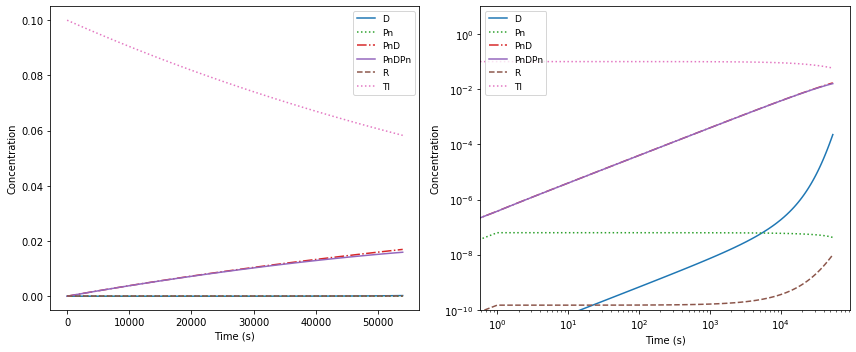

In [84]:
# Plot the concentrations of species in the reaction system vs time 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
     _ = result.plot(names=[k for k in rsys_orig.substances if k != 'CuIsour' \
                            and k != 'M' and k!= 'elec' and k != 'Cu0'], ax=ax) 
     _ = ax.legend(loc='best', prop={'size': 9})
     _ = ax.set_xlabel('Time (s)')
     _ = ax.set_ylabel('Concentration')
_ = axes[1].set_ylim([1e-10, 1e1])
_ = axes[1].set_xscale('log')
_ = axes[1].set_yscale('log')
_ = fig.tight_layout()

#### Meanings of the species produced during the polymerization

R: primary radical either from RX or from thermal initiator  
D: termination product from primary radicals  
Pn: propagating polymer chain with a chain end radical  
PnD: dead polymer chain produced by termination through disproportionation  
PnDPn: dead polymer chain produced by termination through coupling  
PnX: dormant polymer chain with an active chain end  
RXR, RXPn and PnXPn: the intermediate addition products in RAFT polymerization, i.e., the intermediate radicals.  

In [85]:
# Get concentrations and calculate conversion, Mn and Mw/Mn.
ConcM = result[1][:,result.odesys.names.index('M')]
ConcD = result[1][:,result.odesys.names.index('D')]
ConcPnD = result[1][:,result.odesys.names.index('PnD')]
ConcPnDPn = result[1][:,result.odesys.names.index('PnDPn')]
ConcPn = result[1][:,result.odesys.names.index('Pn')]
ConcM2_total = result[1][:,result.odesys.names.index('M2_total')]

if Poly_type != 'conven':
    ConcPnX = result[1][:,result.odesys.names.index('PnX')]
else:
    ConcPnX = np.zeros(len(result[0]))
    
if Poly_type == 'raft':
    ConcPnXPn = result[1][:,result.odesys.names.index('PnXPn')]
    ConcRXPn = result[1][:,result.odesys.names.index('RXPn')]
else:
    ConcPnXPn = np.zeros(len(result[0]))
    ConcRXPn = np.zeros(len(result[0]))

ConvM =(ConcM[0]-ConcM)/ConcM[0]
LnM0_M = np.log(ConcM[0]/ConcM)

Mn = np.zeros(len(result[0]))
Mn_th = np.zeros(len(result[0]))
Mw = np.zeros(len(result[0]))
Mw_Mn = np.ones(len(result[0]))

Mn[1:] = (ConcM[0]-ConcM[1:])/(ConcPnX[1:] + ConcPnD[1:] + ConcPnDPn[1:] + \
                               ConcPn[1:] + ConcPnXPn[1:] + ConcRXPn[1:])*MM
Mn_th[1:] = (ConcM[0]-ConcM[1:])/c0_RX*MM
Mw[1:] = ConcM2_total[1:]/(ConcM[0]-ConcM[1:])*MM    
Mw_Mn[1:] = Mw[1:]/Mn[1:]

# Get mole percent of end group loss, i.e., Tmol%.
if Poly_type != 'conven':
    x=result.odesys.names.index('RX')
    Tmol = 100*(ConcD + ConcPnD + 2*ConcPnDPn)/result[1][0,x]
else:
    Tmol = 100*np.ones(len(result[0]))
    
result_cal = [result[0],ConcM,ConvM,LnM0_M,Mn,Mw_Mn,Tmol]

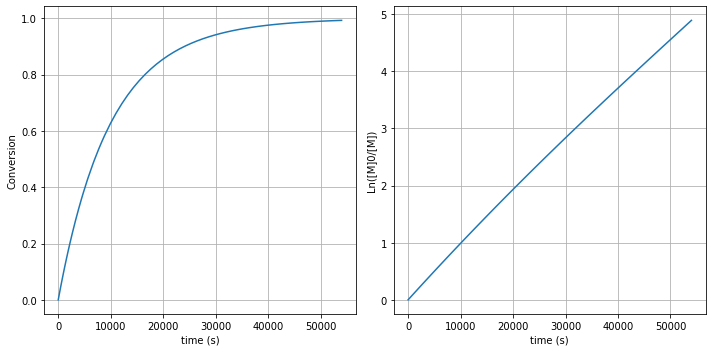

In [86]:
# Monomer conversion vs. time and first order kinetic plots. 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
i=2
for ax in axes:
    _ = ax.plot(result_cal[0], result_cal[i])
    _ = ax.grid()
    i += 1
_ = axes[0].set(xlabel = 'time (s)', ylabel='Conversion')
_ = axes[1].set(xlabel = 'time (s)', ylabel='Ln([M]0/[M])')
_ = fig.tight_layout()

Tmol% does not apply to conventional radical polymerization.


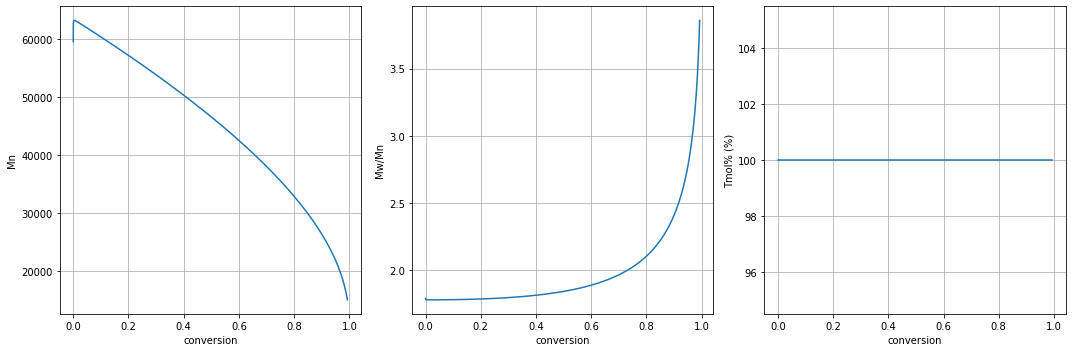

In [87]:
# Plot the Mn, Mw/Mn and Tmol% vs. conversion. 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i=4
for ax in axes:
    _ = ax.plot(result_cal[2][1:], result_cal[i][1:])
    _ = ax.grid()
    i += 1
_ = axes[0].set(xlabel = 'conversion', ylabel='Mn')
_ = axes[1].set(xlabel = 'conversion', ylabel='Mw/Mn')
_ = axes[2].set(xlabel = 'conversion', ylabel='Tmol% (%)')
_ = fig.tight_layout()

if Poly_type == 'conven':
    print('Tmol% does not apply to conventional radical polymerization.')

## Export the results

In [88]:
# Export the result to a CSV file.
# The CSV file is saved in the same folder as this ipynb file. 

now = datetime.datetime.now()
filename = str(now.strftime("%Y-%m-%d-%Hh%Mm%Ss")) + '-RDRP-Simulation-' + str(Poly_type) + '.csv'

with open(filename, 'w', newline='') as f:
    thewriter = csv.writer(f)
    for rxn in rsys_orig.rxns:
        thewriter.writerow([rxn])
    if Poly_type == 'conven':
        thewriter.writerow(['Tmol% does not apply to conventional radical polymerization.'])
    thewriter.writerow(['time (s)']+[k for k in rsys_orig.substances]+['conversion']+['ln([M]0/[M])']\
                       +['Mn']+['Mw/Mn']+['Tmol% (%)'])
    i=0
    for concen in result[1]:
        thewriter.writerow([result_cal[0][i]]+[concen[result.odesys.names.index(k)] for k in rsys_orig.substances]\
                           +[ConvM[i]]+[LnM0_M[i]]+[Mn[i]]+[Mw_Mn[i]]+[Tmol[i]])
        i+=1